Data analysis and cleaning if needed


Attribute Information

1...50: Average, standard deviation, min, max and median of the Attributes 51...60 for the source of the current blog post With source we mean the blog on which the post appeared. For example, myblog.blog.org would be the source of the post myblog.blog.org/post_2010_09_10
51: Total number of comments before basetime 
52: Number of comments in the last 24 hours before the basetime 
53: Let T1 denote the datetime 48 hours before basetime, Let T2 denote the datetime 24 hours before basetime. This attribute is the number of comments in the time period between T1 and T2 
54: Number of comments in the first 24 hours after the publication of the blog post, but before basetime 
55: The difference of Attribute 52 and Attribute 53 
56...60: The same features as the attributes 51...55, but features 56...60 refer to the number of links (trackbacks), while features 51...55 refer to the number of comments. 
61: The length of time between the publication of the blog post and basetime 
62: The length of the blog post 
63...262: The 200 bag of words features for 200 frequent words of the text of the blog post 
263...269: binary indicator features (0 or 1) for the weekday (Monday...Sunday) of the basetime 
270...276: binary indicator features (0 or 1) for the weekday (Monday...Sunday) of the date of publication of the blog post 
277: Number of parent pages: we consider a blog post P as a parent of blog post B, if B is a reply (trackback) to blog post P. 
278...280: Minimum, maximum, average number of comments that the parents received 
281: The target: the number of comments in the next 24 hours (relative to basetime)

In [125]:
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
import numpy as np

In [258]:
df = pd.read_csv('/Users/edwardsujono/Python_Project/blog_feed_analytic/data/blogData_train.csv')
df.columns = range(df.shape[1])

In [259]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
4,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# # DATA SELECTION

Use just feature 1-62, 262-280, based on rationality

In [128]:
column_list = list(range(62)) + list(range(262,280))


df_y = df[280].astype(np.int64)
df_x = df[column_list].astype(np.int64)

Feature selection by wraper, use quick model like random forest regression to test

In [129]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), df_y.as_matrix(), test_size=0.05, random_state=0)

Use Random Forest Regression

In [ ]:
from sklearn.svm import *
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 100, verbose = 2, n_jobs = -1)

model.fit(X_train,Y_train)

Check accuracy with r^2 and mean square error

In [28]:
from sklearn.metrics import mean_squared_error
import math

Y_pred = model.predict(X_train)
print(math.sqrt(mean_squared_error(Y_train, Y_pred)))

print (model.score(X_test,Y_test))

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


9.87353015845
0.41885279701


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Use just feature 1-62, since it is less feature and quite reasonable to use it

In [30]:
column_list = list(range(62))
df_y = df[280].astype(np.int64)
df_x = df[column_list].astype(np.int64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), df_y.as_matrix(), test_size=0.05, random_state=0)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)
print(math.sqrt(mean_squared_error(Y_train, Y_pred)))
print (model.score(X_test,Y_test))

building tree 1 of 100building tree 3 of 100

building tree 2 of 100building tree 4 of 100
building tree 5 of 100

building tree 7 of 100building tree 6 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100 building tree 31 of 100

building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.5s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


10.3739935116
0.474137810564


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


# DATA TRANSFORMATION

## USING FUNCTION TRANSFORMATION

FIRST WE ARE DOING DATA VISUALIZATION TO KNOW THE RELATION BETWEEN EACH FEATURE RESPECT TO THE Y

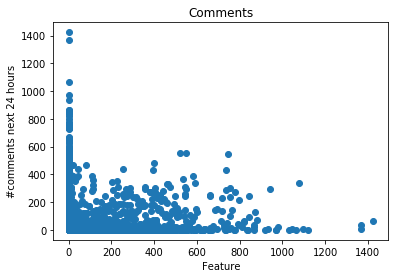

In [70]:
import matplotlib.pyplot as plt

%matplotlib inline

list_x_point = df[52]
list_y_point = df[280]

x_label = "Feature"
y_label = "#comments next 24 hours"
title = "Comments"

plt.figure()
plt.scatter(list_x_point,list_y_point)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()

 By using the log transformation we can reduce the range of the Y

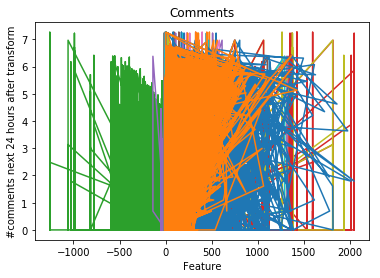

In [198]:
from sklearn.preprocessing import FunctionTransformer

# transformer = FunctionTransformer(lambda x: np.log1p(x))
list_y_point = np.log1p(df[280])
# list_y_point = df[280]
list_x_point = df[range(52)]


x_label = "Feature"
y_label = "#comments next 24 hours after transform"
title = "Comments"

plt.figure()
# plt.scatter(list_x_point,list_y_point)
plt.plot(list_x_point, list_y_point)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()

This visualization shows that each of the feature has a weak correlation with the Y, which means most of the X contribute to the number of next comments, By having log transformation the Y got fewer range meaning the classification job would be much easier

## USING CATEGORIZATION

check the range of the feature data first

In [171]:
df_x = df[list(range(10,20))]
df_x

,10,11,12,13,14,15,16,17,18,19
0,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0
1,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0
2,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0
3,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0
4,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0
5,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0
6,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0
7,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0
8,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0
9,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0


In [77]:
np.percentile(df[1], 25)

5.2143182999999995

In [78]:
np.percentile(df[1], 50)

19.353120000000001

In [79]:
np.percentile(df[1], 75)

77.442830000000001

In [81]:
np.percentile(df[1], 99)

355.35034000000002

In [172]:
import copy

df_categorization = copy.deepcopy(df)

# df_categorization.loc[df_categorization[0] > 10, 0] = 0
for i in range(50,62):
    first = np.percentile(df[i], 25)
    second = np.percentile(df[i], 50)
    third = np.percentile(df[i], 75)
    
    df_categorization.loc[df_categorization[i] < first, i] = 0
    df_categorization.loc[(df_categorization[i] >= first) & (df_categorization[i] < second), i] = 1
    df_categorization.loc[(df_categorization[i] >= second) & (df_categorization[i] < third), i] = 2
    df_categorization.loc[df_categorization[i] >= third, i] = 3
#     print ("i: %s , first: %s, second: %s, third: %s " % (i, first, second, third))
#     print(df_categorization[i])

df_categorization

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,40.304670,53.845657,0.0,401.0,15.0,15.524160,32.441880,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40.304670,53.845657,0.0,401.0,15.0,15.524160,32.441880,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.304670,53.845657,0.0,401.0,15.0,15.524160,32.441880,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,40.304670,53.845657,0.0,401.0,15.0,15.524160,32.441880,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
4,40.304670,53.845657,0.0,401.0,15.0,15.524160,32.441880,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,40.304670,53.845657,0.0,401.0,15.0,15.524160,32.441880,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,40.304670,53.845657,0.0,401.0,15.0,15.524160,32.441880,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
7,40.304670,53.845657,0.0,401.0,15.0,15.524160,32.441880,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
8,40.304670,53.845657,0.0,401.0,15.0,15.524160,32.441880,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
9,40.304670,53.845657,0.0,401.0,15.0,15.524160,32.441880,0.0,377.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
from sklearn.ensemble import *
from sklearn.linear_model import *


column_list = list(range(62))

df_y_categorization = df_categorization[280].astype(np.int64)
df_x_categorization = df_categorization[column_list].astype(np.int64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x_categorization.as_matrix(), df_y_categorization.as_matrix(),
                                                    test_size=0.05, random_state=0)

model = RandomForestRegressor(n_estimators = 100,verbose = 2,n_jobs =-1,oob_score=True)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)
print("msqr: %s" % math.sqrt(mean_squared_error(Y_train, Y_pred)))
print ("score: %s" % model.score(X_test,Y_test))

building tree 2 of 100 
building tree 1 of 100 building tree 3 of 100

building tree 6 of 100building tree 5 of 100building tree 4 of 100


building tree 7 of 100building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.4s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


msqr: 24.1887608565
score: 0.319549783526


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


We have tried using categorization but end up with value loss. so it means we cannot reduce any value again.

# DATA MINING

## LINEAR REGRESSION WITHOUT TRANSFORMATION FUNCTION

In [217]:
from sklearn.ensemble import *
from sklearn.linear_model import *

column_list = list(range(62))

df_y = df[280].astype(np.int64)
df_x = df[column_list].astype(np.int64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x_categorization.as_matrix(), df_y_categorization.as_matrix(),
                                                    test_size=0.05, random_state=0)

model = LinearRegression(n_jobs = -1)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)
print(math.sqrt(mean_squared_error(Y_train, Y_pred)))
print (model.score(X_test,Y_test))

31.515510825
0.158907698804


## LINEAR REGRESSION WITH TRANSFORMATION FUNCTION

In [218]:
from sklearn.metrics import *
from math import exp

column_list = list(range(62))

df_y = df[280].astype(np.int64)
y_trans = np.log2(1+df_y)
df_x = df[column_list].astype(np.float64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), y_trans,test_size=0.5, random_state=0)

model = LinearRegression(n_jobs = -1)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
print(r2_score(2**Y_test, 2**Y_pred))
print (model.score(X_test,Y_test))


-103.379298311
0.467834270763


with linear regression it is making the prediction extremely bad, -12 means it is worse than deduce the value as the mean

## RANDOM FOREST REGRESSION WITHOUT TRANSFORMATION FUNCTION

In [219]:
column_list = list(range(62))

df_y = df[280].astype(np.int64)
df_x = df[column_list].astype(np.int64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x_categorization.as_matrix(), df_y_categorization.as_matrix(),
                                                    test_size=0.5, random_state=0)

model = RandomForestRegressor(n_estimators = 100, verbose = 2, n_jobs = -1)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)
print(math.sqrt(mean_squared_error(Y_train, Y_pred)))
print (model.score(X_test,Y_test))

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100
building tree 6 of 100  
building tree 8 of 100

building tree 5 of 100building tree 7 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 15 of 100
building tree 14 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100building tree 23 of 100

building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
 building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
 building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
 building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


23.5525940012
0.466576203569


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


## RANDOM FOREST WITH TRANSFORMATION FUNCTION

In [221]:
column_list = list(range(62))

df_y = df[280].astype(np.int64)
y_trans = np.log1p(df_y)
df_x = df[column_list].astype(np.float64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), y_trans,test_size=0.5, random_state=0)

model = RandomForestRegressor(n_estimators = 50, verbose = 2, n_jobs = -1)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
print(r2_score(np.exp(Y_test)-1, np.exp(Y_pred)-1 ))
print (model.score(X_test,Y_test))


building tree 1 of 50
building tree 4 of 50building tree 2 of 50  building tree 5 of 50building tree 8 of 50building tree 7 of 50

building tree 3 of 50building tree 6 of 50




building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50building tree 14 of 50

building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
 building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


0.528120684253
0.654807362281


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


## GRADIENT BOOSTING WITH TRANSFORMATION FUNCTION

In [222]:
column_list = list(range(62))

df_y = df[280].astype(np.int64)
y_trans = np.log1p(df_y)
df_x = df[column_list].astype(np.float64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), y_trans,test_size=0.5, random_state=0)

model = GradientBoostingRegressor(loss = 'huber',n_estimators = 100,verbose = 2)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
print(r2_score(np.exp(Y_test)-1, np.exp(Y_pred)-1 ))
print (model.score(X_test,Y_test))

      Iter       Train Loss   Remaining Time 
         1           0.6482            7.81s
         2           0.5726            7.78s
         3           0.5147            7.47s
         4           0.4614            7.41s
         5           0.4200            7.38s
         6           0.3841            7.23s
         7           0.3546            7.25s
         8           0.3289            7.13s
         9           0.3099            7.05s
        10           0.2946            6.88s
        11           0.2796            6.74s
        12           0.2692            6.63s
        13           0.2606            6.62s
        14           0.2529            6.54s
        15           0.2455            6.43s
        16           0.2403            6.34s
        17           0.2357            6.24s
        18           0.2306            6.14s
        19           0.2265            6.04s
        20           0.2225            5.97s
        21           0.2192            5.89s
        2

In [ ]:
column_list = list(range(62))

df_y = df[280].astype(np.int64)
df_x = df[column_list].astype(np.float64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), df_y,test_size=0.5, random_state=0)

model = GradientBoostingRegressor(loss = 'huber',n_estimators = 100,verbose = 2)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
print(r2_score(Y_test, Y_pred ))
print (model.score(X_test,Y_test))

Summing up in here, Linear regression with transformation function perform worse than non-transformation function because as we can see in the visualization part that there is barely correlation between feature and the number of comments given. On the other hand, the random forest regression with transformation function is better than the non-transformed one -> we deduce this is caused by the less range of the comments number.

## CHECK WITH TEST DATA

In [227]:
df_test = pd.read_csv('/Users/edwardsujono/Python_Project/blog_feed_analytic/data/comine_data.csv')

In [228]:
df_test.columns = range(df_test.shape[1])

GRADIENT BOOSTING

In [241]:
column_list = list(range(62))

df_y = df_test[280].astype(np.int64)
y_trans = np.log1p(df_y)
df_x = df_test[column_list].astype(np.float64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), y_trans,test_size=0.5, random_state=0)

model = GradientBoostingRegressor(loss = 'huber',n_estimators = 50,verbose = 2)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
print(r2_score(np.exp(Y_test)-1, np.exp(Y_pred)-1 ))
print (model.score(X_test,Y_test))

      Iter       Train Loss   Remaining Time 
         1           0.4880            0.49s
         2           0.4225            0.50s
         3           0.3765            0.51s
         4           0.3421            0.50s
         5           0.3102            0.48s
         6           0.2828            0.47s
         7           0.2636            0.46s
         8           0.2455            0.44s
         9           0.2309            0.43s
        10           0.2190            0.41s
        11           0.2087            0.40s
        12           0.2013            0.38s
        13           0.1925            0.37s
        14           0.1866            0.35s
        15           0.1808            0.34s
        16           0.1759            0.33s
        17           0.1712            0.31s
        18           0.1680            0.30s
        19           0.1646            0.29s
        20           0.1611            0.28s
        21           0.1584            0.27s
        2

RANDOM FOREST REGRESSION

In [244]:
column_list = list(range(62))

df_y = df_test[280].astype(np.int64)
y_trans = np.log1p(df_y)
df_x = df_test[column_list].astype(np.float64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), y_trans,test_size=0.5, random_state=0)

model = RandomForestRegressor(n_estimators = 50, verbose = 2, n_jobs = -1)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)

print(r2_score(np.exp(Y_test)-1, np.exp(Y_pred)-1 ))
print (model.score(X_test,Y_test))

building tree 2 of 50
building tree 1 of 50building tree 3 of 50 building tree 5 of 50building tree 6 of 50building tree 7 of 50building tree 8 of 50

building tree 4 of 50




building tree 9 of 50building tree 10 of 50building tree 11 of 50


building tree 12 of 50building tree 13 of 50
 building tree 14 of 50
 
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50building tree 20 of 50

building tree 21 of 50building tree 22 of 50

building tree 23 of 50building tree 24 of 50

building tree 25 of 50
building tree 26 of 50building tree 27 of 50

building tree 28 of 50
building tree 29 of 50building tree 30 of 50

building tree 32 of 50building tree 31 of 50

building tree 33 of 50building tree 34 of 50

building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50building tree 39 of 50building tree 40 of 50


building tree 41 of 50building tree 42 of 50building tree 43 of 50


building tree 45 

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


0.413510436437
0.645694959411


## USING NEURAL NETWORK

Using neural network should give good result if there is a correlation between feature and the number of comments, but as we can see from the visualization part the correlation between feature and label quite poort 

## NEW FINDING

In the data we find that several attributes are related with the base time, so to remove that dependency we divide those several attribute with the base time such that the attribute became rate instead of the pure number.

In [260]:
HOUR_PER_DAY = 24
ZERO = 0
ONE = 1

df[281] = np.array([HOUR_PER_DAY for i in range(len(df))])
df[282] = np.array([ ZERO for i in range(len(df))])
df[283] = np.array([ ONE for i in range(len(df))])


In [261]:
for k in range(6):
    df[10*k+0] = df[10*k+0] / (df[60]+df[283])
    df[10*k+5] = df[10*k+5] / (df[60]+df[283])
#     df2[10*k+0] = df2[10*k+0] / (df2[60]+df2[283])
#     df2[10*k+5] = df2[10*k+5] / (df2[60]+df2[283])

for k in range(6):
    df[10*k+1] = df[10*k+1] / (np.minimum(df[60],df[281])+df[283])
    df[10*k+6] = df[10*k+6] / (np.minimum(df[60],df[281])+df[283])
#     df2[10*k+1] = df2[10*k+1] / (np.minimum(df2[60],df2[281])+df2[283])
#     df2[10*k+6] = df2[10*k+6] / (np.minimum(df2[60],df2[281])+df2[283])
    
for k in range(6):
    df[10*k+2] = df[10*k+2] / (np.minimum(np.maximum(df[60] - df[281],df[282]),df[281])+df[283])
    df[10*k+7] = df[10*k+7] / (np.minimum(np.maximum(df[60] - df[281],df[282]),df[281])+df[283])
#     df2[10*k+2] = df2[10*k+2] / (np.minimum(np.maximum(df2[60] - df2[281],df2[282]),df2[281])+df2[283])
#     df2[10*k+7] = df2[10*k+7] / (np.minimum(np.maximum(df2[60] - df2[281],df2[282]),df2[281])+df2[283])
    

for k in range(6):
    df[10*k+3] = df[10*k+3] / (np.minimum(df[60],df[281])+df[283])
    df[10*k+8] = df[10*k+8] / (np.minimum(df[60],df[281])+df[283])
#     df2[10*k+3] = df2[10*k+3] / (np.minimum(df2[60],df2[281])+df2[283])
#     df2[10*k+8] = df2[10*k+8] / (np.minimum(df2[60],df2[281])+df2[283])
    
    

for k in range(6):
    df[10*k+3] = df[10*k+3] / (np.minimum(df[60],df[281])+df[283])
    df[10*k+8] = df[10*k+8] / (np.minimum(df[60],df[281])+df[283])
#     df2[10*k+3] = df2[10*k+3] / (np.minimum(df2[60],df2[281])+df2[283])
#     df2[10*k+8] = df2[10*k+8] / (np.minimum(df2[60],df2[281])+df2[283])


df[280] = df[280] / (df[281]+df[283])
# df2[280] = df2[280] / (df2[281]+df2[283])


df = df.fillna(0)
# df2 = df2.fillna(0)

In [262]:
column_list = list(range(62))

df_y = df[280].astype(np.int64)
y_trans = np.log1p(df_y)
df_x = df[column_list].astype(np.float64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), y_trans,test_size=0.5, random_state=0)

model = RandomForestRegressor(n_estimators = 7, verbose = 2, n_jobs = -1)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
print(r2_score(np.exp(Y_test)-1, np.exp(Y_pred)-1 ))
print (model.score(X_test,Y_test))

building tree 1 of 7building tree 3 of 7building tree 2 of 7 

building tree 4 of 7

building tree 5 of 7 building tree 6 of 7
building tree 7 of 7



[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s finished
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished


0.501600490932
0.51427301669


[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished


In [250]:
column_list = list(range(62))

df_y = df[280].astype(np.int64)
y_trans = np.log1p(df_y)
df_x = df[column_list].astype(np.float64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), y_trans,test_size=0.5, random_state=0)

model = GradientBoostingRegressor(loss = 'huber',n_estimators = 1000,verbose = 2)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
print(r2_score(np.exp(Y_test)-1, np.exp(Y_pred)-1 ))
print (model.score(X_test,Y_test))

      Iter       Train Loss   Remaining Time 
         1           0.0000            3.56s
         2           0.0000            3.29s
         3           0.0000            3.19s
         4           0.0000            3.12s
         5           0.0000            3.10s
         6           0.0000            3.07s
         7           0.0000            3.04s
         8           0.0000            3.05s
         9           0.0000            3.05s
        10           0.0000            3.04s
        11           0.0000            3.03s
        12           0.0000            3.03s
        13           0.0000            3.03s
        14           0.0000            3.02s
        15           0.0000            3.01s
        16           0.0000            3.01s
        17           0.0000            3.01s
        18           0.0000            2.99s
        19           0.0000            2.98s
        20           0.0000            2.99s
        21           0.0000            2.98s
        2

       193           0.0000            2.55s
       194           0.0000            2.54s
       195           0.0000            2.54s
       196           0.0000            2.54s
       197           0.0000            2.54s
       198           0.0000            2.53s
       199           0.0000            2.53s
       200           0.0000            2.53s
       201           0.0000            2.53s
       202           0.0000            2.52s
       203           0.0000            2.52s
       204           0.0000            2.52s
       205           0.0000            2.52s
       206           0.0000            2.52s
       207           0.0000            2.51s
       208           0.0000            2.51s
       209           0.0000            2.51s
       210           0.0000            2.50s
       211           0.0000            2.50s
       212           0.0000            2.50s
       213           0.0000            2.49s
       214           0.0000            2.49s
       215

       434           0.0000            1.85s
       435           0.0000            1.84s
       436           0.0000            1.84s
       437           0.0000            1.84s
       438           0.0000            1.83s
       439           0.0000            1.83s
       440           0.0000            1.83s
       441           0.0000            1.82s
       442           0.0000            1.82s
       443           0.0000            1.82s
       444           0.0000            1.82s
       445           0.0000            1.81s
       446           0.0000            1.81s
       447           0.0000            1.81s
       448           0.0000            1.80s
       449           0.0000            1.80s
       450           0.0000            1.80s
       451           0.0000            1.79s
       452           0.0000            1.79s
       453           0.0000            1.79s
       454           0.0000            1.78s
       455           0.0000            1.78s
       456

       674           0.0000            1.08s
       675           0.0000            1.07s
       676           0.0000            1.07s
       677           0.0000            1.07s
       678           0.0000            1.06s
       679           0.0000            1.06s
       680           0.0000            1.06s
       681           0.0000            1.05s
       682           0.0000            1.05s
       683           0.0000            1.05s
       684           0.0000            1.04s
       685           0.0000            1.04s
       686           0.0000            1.04s
       687           0.0000            1.03s
       688           0.0000            1.03s
       689           0.0000            1.03s
       690           0.0000            1.02s
       691           0.0000            1.02s
       692           0.0000            1.02s
       693           0.0000            1.01s
       694           0.0000            1.01s
       695           0.0000            1.01s
       696

       918           0.0000            0.27s
       919           0.0000            0.27s
       920           0.0000            0.26s
       921           0.0000            0.26s
       922           0.0000            0.26s
       923           0.0000            0.25s
       924           0.0000            0.25s
       925           0.0000            0.25s
       926           0.0000            0.24s
       927           0.0000            0.24s
       928           0.0000            0.24s
       929           0.0000            0.23s
       930           0.0000            0.23s
       931           0.0000            0.23s
       932           0.0000            0.22s
       933           0.0000            0.22s
       934           0.0000            0.22s
       935           0.0000            0.21s
       936           0.0000            0.21s
       937           0.0000            0.21s
       938           0.0000            0.21s
       939           0.0000            0.20s
       940